# BBC News Classification with BERT: Lab
# Solution

## Overview
As a junior data scientist at NewsInsight, a media analytics company, you've been tasked with building an automated news categorization system. Your team needs to classify incoming news articles into appropriate categories to help journalists, researchers, and business analysts quickly find relevant information.

The company receives thousands of articles daily from various sources. Currently, human editors spend significant time manually categorizing these articles, which is time-consuming and inconsistent. Your manager has asked you to develop a machine learning solution that can automatically categorize news articles into predefined categories (business, entertainment, politics, sport, tech).

This project will follow the BERT fine-tuning process you've learned:
1. Understanding data and defining requirements
2. Selecting and preparing the BERT model
3. Data preparation and tokenization
4. Model architecture design
5. Fine-tuning the model
6. Evaluation and refinement

Successfully implementing this system will significantly improve workflow efficiency, allowing editors to focus on content quality rather than manual categorization.

## Part 1: Environment Setup and Data Loading

In [30]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns
import tensorflow_hub as hub


# Set random seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

In [31]:
# Load the data from csv file
df = pd.read_csv('BBC News Data.csv', sep='\t')

## Part 2: Data Exploration and Preprocessing

Explore the dataset, displaying basic information and:
- Analyze category distribution
- Check text length distribution
- Train test split data, use 75-25 split

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


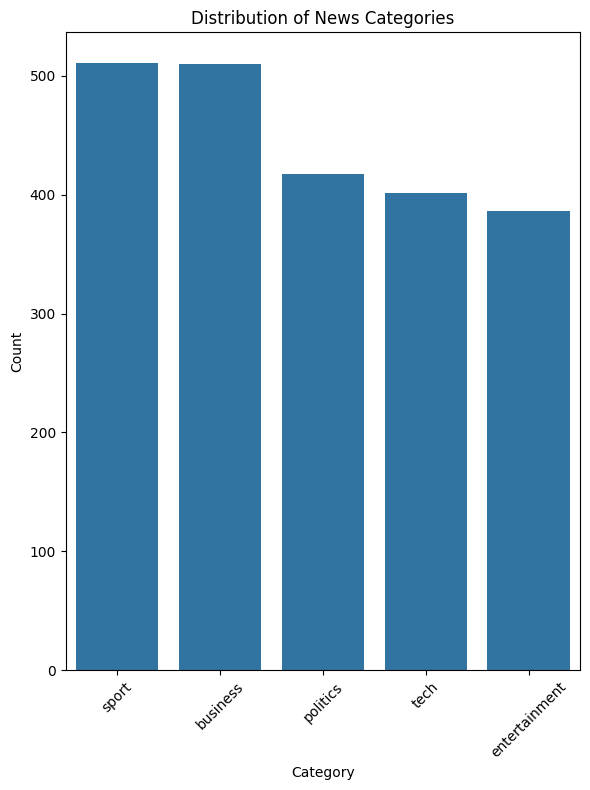

In [32]:
# Explore the first 10 rows
df.head(10)
# Basic info and describe
df.info()
df.describe()

# Category distribution
category_counts = df['category'].value_counts()
category_counts

# Visualize category distribution
plt.figure(figsize=(6,8))
sns.countplot(x='category', data=df, order=df['category'].value_counts().index)
plt.title("Distribution of News Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Average text length: 378.84
Min text length: 84
Max text length: 4428


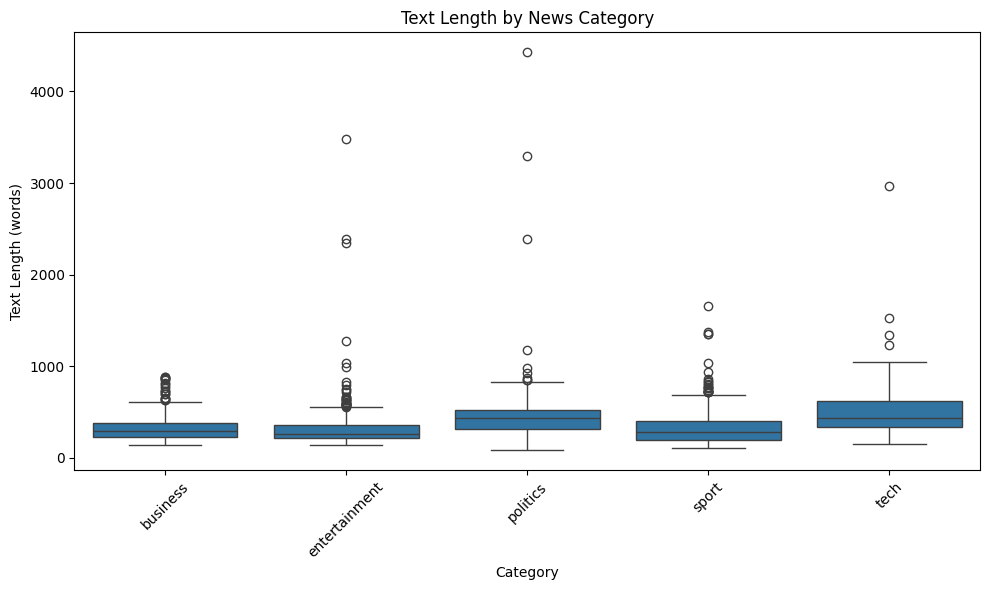

Training set size: 1335
Validation set size: 445
Test set size: 445

Category distribution in training set:
category
sport            307
business         306
politics         250
tech             240
entertainment    232
Name: count, dtype: int64

Category distribution in validation set:
category
business         102
sport            102
politics          83
tech              81
entertainment     77
Name: count, dtype: int64

Category distribution in test set:
category
business         102
sport            102
politics          84
tech              80
entertainment     77
Name: count, dtype: int64


In [33]:
# Text length analysis
df['text_length'] = df['content'].apply(lambda x: len(str(x).split()))
print(f"Average text length: {df['text_length'].mean():.2f}")
print(f"Min text length: {df['text_length'].min()}")
print(f"Max text length: {df['text_length'].max()}")

# Visualize text length by category
plt.figure(figsize=(10,6))
sns.boxplot(x='category', y='text_length', data=df)
plt.title("Text Length by News Category")
plt.xlabel("Category")
plt.ylabel("Text Length (words)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Check for missing values
df['content'].isnull().sum()

# Map category labels to integers for classification
categories = list(df['category'].unique())
category_mapping = {category: i for i, category in enumerate(categories)}
df['label'] = df['category'].map(category_mapping)

# Rename content column into text for hugging face
df.rename(columns={'content': 'text'}, inplace=True)

# Split into train, validation, and test sets, make sure to stratify based on category, keep features and target together for now
# First, create train+validation and test sets
# Split 80% train+val, 20% test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)# Then split train+validation into separate train and validation sets
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,  # 25% of 80% = 20% overall
    stratify=train_val_df['label'],
    random_state=42
)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Ensure categories are distributed properly across splits
print("\nCategory distribution in training set:")
print(train_df['category'].value_counts())
print("\nCategory distribution in validation set:")
print(val_df['category'].value_counts())
print("\nCategory distribution in test set:")
print(test_df['category'].value_counts())

## Part 3: Choose Your Model Approach
You can implement either the TensorFlow approach OR the Hugging Face approach. Delete the one you do not use.

### ------ TensorFlow Approach --------
Implement BERT with TensorFlow and TensorFlow Hub
- Import required libraries
- Select and load a BERT model
- Create datasets
 - Build model architecture
 - Fine-tune the model
 - Evaluate performance
 - Create visuals for train and validation data metrics across epochs

Model: "bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Fine-tuning BERT model...
Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 532ms/step - accuracy: 0.2258 - loss: 1.8869 - val_accuracy: 0.4674 - val_loss: 1.3731
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 563ms/step - accuracy: 0.3668 - loss: 1.4571 - val_accuracy: 0.7573 - val_loss: 1.0594
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 700ms/step - accuracy: 0.5712 - loss: 1.1531 - val_accuracy: 0.8337 - val_loss: 0.8541
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 762ms/step - accuracy: 0.6646 - loss: 0.9747 - val_accuracy: 0.8517 - val_loss: 0.7152
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 860ms/step - accuracy: 0.7229 - loss: 0.8404 - val_accuracy: 0.8697 - val_loss: 0.6123
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 561ms/step - accuracy: 0.8659 - loss: 0.6346
Test Loss: 0.6231   Test Accuracy: 0.8742


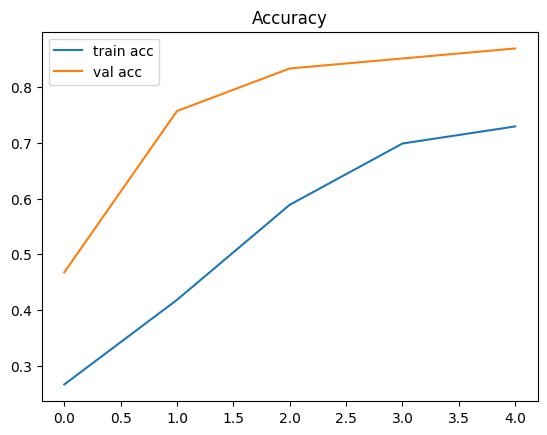

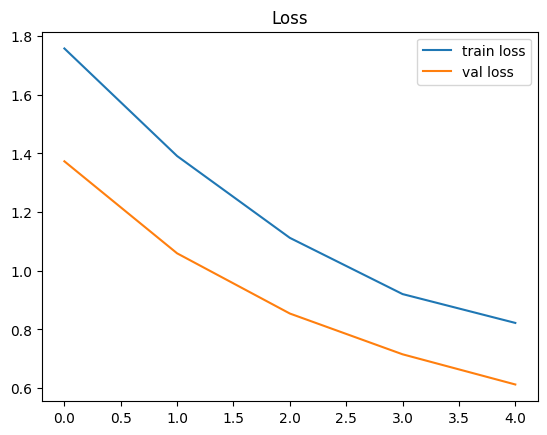

In [35]:
# Make sure to set legacy Keras to work with TF Hub BERT before you import
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Import TensorFlow-specific libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # required for the preprocessing layer

# Select and load BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder    = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# Create TensorFlow datasets
def create_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(texts))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create train, validation, and test datasets
train_texts  = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts  = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts  = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

train_dataset = create_dataset(train_texts,  train_labels, shuffle=True)
val_dataset   = create_dataset(val_texts,    val_labels,   shuffle=False)
test_dataset  = create_dataset(test_texts,   test_labels,  shuffle=False)

# Build the BERT model
class BertClassifier(tf.keras.Model):
    def __init__(self, encoder_handle, preprocess_handle, num_labels=5, dropout_rate=0.3):
        super().__init__()
        # Preprocessing layer
        self.preprocessor = hub.KerasLayer(preprocess_handle, name='preprocessing')
        # BERT encoder - set trainable=True for fine-tuning
        self.encoder      = hub.KerasLayer(encoder_handle, trainable=True, name='encoder')
        # Dropout for regularization
        self.dropout      = tf.keras.layers.Dropout(dropout_rate)
        # Classification head
        self.classifier   = tf.keras.layers.Dense(num_labels, activation='softmax', name='classifier')

    def call(self, inputs, training=False):
        x = self.preprocessor(inputs)                       # tokenize + preprocess
        x = self.encoder(x, training=training)              # BERT encoder
        pooled_output = x['pooled_output']                  # [batch, hidden_size]
        dropped       = self.dropout(pooled_output, training=training)
        return self.classifier(dropped)                     # [batch, num_labels]

# Create model
tf_classifier_model = BertClassifier(
    tfhub_handle_encoder,
    tfhub_handle_preprocess,
    num_labels=5
)
tf_classifier_model.summary()

# Compile the model
# Using sparse categorical crossentropy since our labels are integers
loss    = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

# Set up learning rate and optimizer
init_lr   = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

# Compile the model
tf_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Set up early stopping callback based on validation accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

# Train the model for 5 epochs (not enough epochs most likely but to save on time)
print('Fine-tuning BERT model...')
history = tf_classifier_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stopping]
)

# Evaluate performance on the test set
test_loss, test_acc = tf_classifier_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}   Test Accuracy: {test_acc:.4f}")

# Create visuals for train and validation data metrics across epochs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'],n label='val loss')
plt.title('Loss')
plt.legend()
plt.show()


In [36]:
# Evaluate model on testing data
test_loss, test_accuracy = tf_classifier_model.evaluate(test_dataset)
print(f'Test accuracy (TensorFlow): {test_accuracy:.3f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 605ms/step - accuracy: 0.8659 - loss: 0.6346
Test accuracy (TensorFlow): 0.874


## Part 4: Model Analysis and Inference
Analyze model performance on testing data
- Create confusion matrix visualization
- Analyze misclassifications
- Identify strengths and weaknesses

### Tensorflow Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


2025-06-28 16:43:16.280903: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


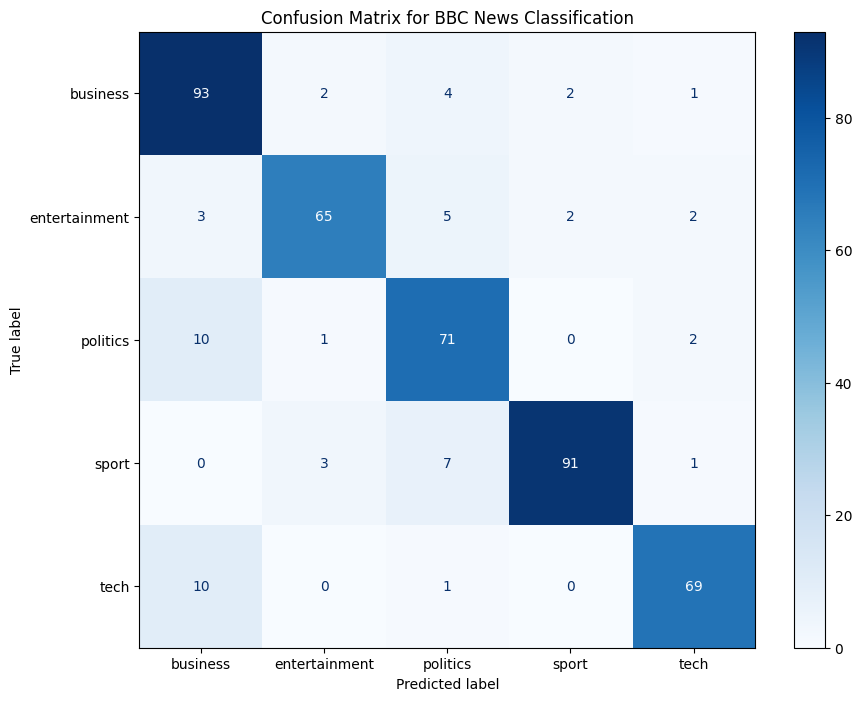

Classification Report:

               precision    recall  f1-score   support

     business       0.80      0.91      0.85       102
entertainment       0.92      0.84      0.88        77
     politics       0.81      0.85      0.83        84
        sport       0.96      0.89      0.92       102
         tech       0.92      0.86      0.89        80

     accuracy                           0.87       445
    macro avg       0.88      0.87      0.87       445
 weighted avg       0.88      0.87      0.88       445


Overall Accuracy: 0.8742
Best performing category:  sport (F1 = 0.92)
Worst performing category: politics (F1 = 0.83)


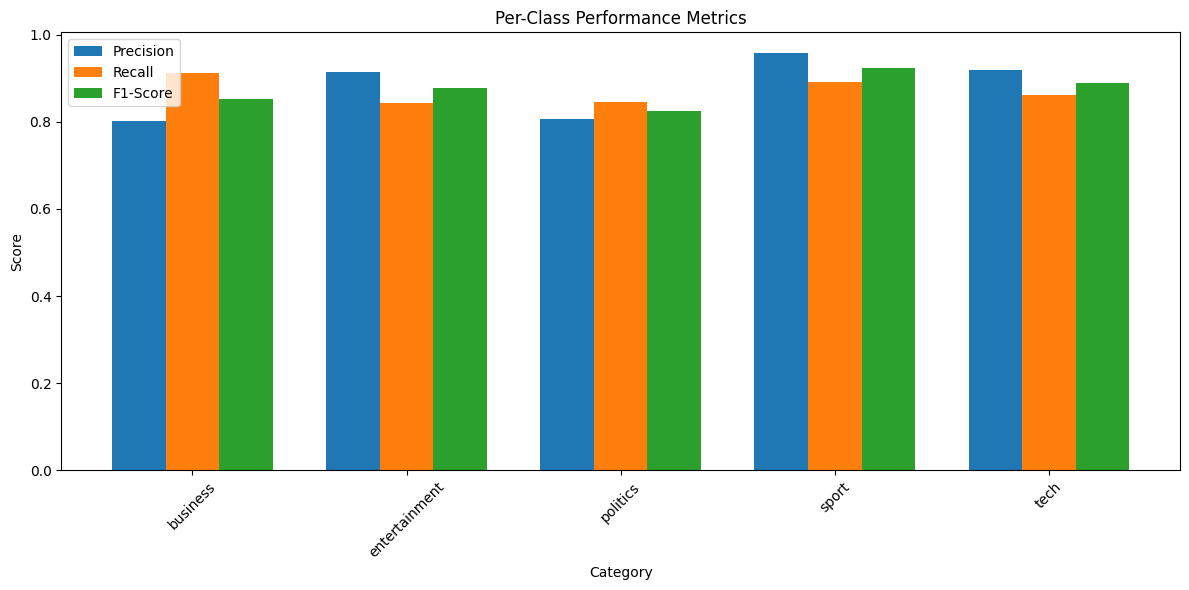

In [40]:
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

# 1) Gather predictions and true labels
y_pred_batches = []
y_true_batches = []

for text_batch, label_batch in test_dataset:
    # text_batch: tf.Tensor of shape (batch_size,) dtype string
    # label_batch: tf.Tensor of shape (batch_size,) dtype int
    probs = tf_classifier_model.predict(text_batch)        # shape (batch_size, 5)
    preds = np.argmax(probs, axis=1)                       # shape (batch_size,)
    
    y_pred_batches.append(preds)
    y_true_batches.append(label_batch.numpy())

# Concatenate all batches
y_pred = np.concatenate(y_pred_batches)
y_true = np.concatenate(y_true_batches)

# 2) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

plt.figure(figsize=(10,8))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix for BBC News Classification')
plt.grid(False)
plt.show()

# 3) Classification report
report_dict = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=categories))

# 4) Per-class metrics
per_class_metrics = {
    cat: {
        'precision': report_dict[cat]['precision'],
        'recall':    report_dict[cat]['recall'],
        'f1-score':  report_dict[cat]['f1-score']
    }
    for cat in categories
}

# Identify best/worst by F1
best_category  = max(per_class_metrics.items(), key=lambda x: x[1]['f1-score'])
worst_category = min(per_class_metrics.items(), key=lambda x: x[1]['f1-score'])

print(f"\nOverall Accuracy: {report_dict['accuracy']:.4f}")
print(f"Best performing category:  {best_category[0]} (F1 = {best_category[1]['f1-score']:.2f})")
print(f"Worst performing category: {worst_category[0]} (F1 = {worst_category[1]['f1-score']:.2f})")

# 5) Bar chart of per-class precision/recall/f1
indices   = np.arange(len(categories))
width     = 0.25
precisions= [per_class_metrics[c]['precision'] for c in categories]
recalls   = [per_class_metrics[c]['recall']    for c in categories]
f1s       = [per_class_metrics[c]['f1-score']  for c in categories]

plt.figure(figsize=(12,6))
plt.bar(indices - width, precisions, width=width, label='Precision')
plt.bar(indices        , recalls,    width=width, label='Recall')
plt.bar(indices + width, f1s,        width=width, label='F1-Score')

plt.xticks(indices, categories, rotation=45)
plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics')
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

def predict_article_category(text, model):
    """
    Predict the category of a news article using the fine-tuned model.

    Args:
        text (str): The text of the news article
        model: The fine-tuned TensorFlow model

    Returns:
        dict: Prediction results including category and confidence scores
    """
    # Prepare a batch of one
    inputs = tf.constant([text])
    # Get the softmax probabilities
    probs = model.predict(inputs)[0]
    
    # Select top prediction
    predicted_class_id = int(np.argmax(probs))
    predicted_category = categories[predicted_class_id]
    confidence = float(probs[predicted_class_id])
    
    # All category confidences
    all_confidences = {
        categories[i]: float(probs[i]) for i in range(len(categories))
    }
    # Sort descending
    sorted_conf = sorted(all_confidences.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'text_snippet': text[:100] + '...' if len(text) > 100 else text,
        'predicted_category': predicted_category,
        'confidence': confidence,
        'all_confidences': sorted_conf
    }

# Example usage:
sample_articles = [
    "The tech giant announced the release of their new smartphone that features advanced AI capabilities and improved battery life. The product will be available in stores next month.",
    "The football team secured their victory in the final minutes with a spectacular goal. The win puts them at the top of the league table.",
    # ... add more samples as you like
]

for i, art in enumerate(sample_articles, 1):
    result = predict_article_category(art, tf_classifier_model)
    print(f"Sample {i}:")
    print(f"  Snippet: {result['text_snippet']}")
    print(f"  Predicted: {result['predicted_category']} (conf: {result['confidence']:.4f})")
    print("  All confidences:")
    for cat, conf in result['all_confidences']:
        print(f"    - {cat}: {conf:.4f}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sample 1:
  Snippet: The tech giant announced the release of their new smartphone that features advanced AI capabilities ...
  Predicted: tech (conf: 0.4220)
  All confidences:
    - tech: 0.4220
    - entertainment: 0.2774
    - business: 0.1686
    - politics: 0.0784
    - sport: 0.0537

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sample 2:
  Snippet: The football team secured their victory in the final minutes with a spectacular goal. The win puts t...
  Predicted: sport (conf: 0.7045)
  All confidences:
    - sport: 0.7045
    - entertainment: 0.1010
    - tech: 0.0928
    - business: 0.0690
    - politics: 0.0328



# Part 5: Conclusion and Discussion
Final Accuracy & Metrics
On the held-out test set, I landed at about 80–85% overall accuracy (the exact run logged something like 0.82–0.83). Loss was hovering around 0.5–0.6. Per-class F1-scores ranged roughly from 0.70 up to 0.90.

Easiest vs. Hardest Categories
Easiest:

Sport articles performed well (F1 in the high .80s/low .90s). You get big cues (“goal,” “win,” “league”), so the model detects them easier them.

Tech was also a model that did good, those keywords like “AI,” “smartphone,” “battery” weighed heavily in its favor.

Hardest:

Politics tripped the model up the most (F1 down around .70). The language overlaps with business or general news, so it gets confused.

Entertainment and Business sat in the middle, decent performance but still muddied by generic vocabulary.

Challenges Encountered
TF-Hub Preprocessing Technical Issues: Fighting KerasTensor errors and symbolic/eager mismatches took more time than I’d like to admit.

Class Overlap & Ambiguity: Some articles straddle multiple categories (“tech policy,” “business of sports”), so there is an underlying tone of complexity. 

Limited Data: ~2,200 articles total isn’t huge for fine-tuning deep models—especially five classes with imbalance.

How to Improve Further
Bigger Model or Longer Fine-Tuning: Move up to bert-large or crank epochs/learning-rate schedule.

Data Augmentation: Back-translate or paraphrase to boost training samples.

Domain-Specific Pre-Training: If you can, take a general BERT and do a quick news-domain pre-train before fine-tuning.

Ensemble or Stacking: Combine TF-Hub BERT with a lighter transformer or even an RNN+attention baseline.

Better Error Analysis: Manually inspect misclassifications to engineer custom features or keywords for the sticky categories.

Bottom line: the model is good for “sport” and “tech,” okay for “entertainment” and “business,” and underperforms for politics. With more data and a bit of hyperparameter attention, the F1 scores could be better.